In [1]:
! pip install split-folders

In [2]:
!wget -O dataset.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
!unzip -qq dataset.zip -d dataset

--2022-12-27 08:00:29--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2022-12-27 08:00:30--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.34.2, 52.218.1.120, 3.5.65.15, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.34.2|:443... con

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras import Model
from keras.metrics import Precision, Recall

import numpy as np
from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [4]:
splitfolders.ratio(
  "/kaggle/working/dataset/Plant_leave_diseases_dataset_with_augmentation", 
  output="/kaggle/working/Final_Dataset",
  seed=7,
  ratio=(0.90, 0.050, 0.050)
)

Copying files: 61486 files [00:09, 6226.53 files/s]


In [5]:
    '''
    rotation_range=355,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.1
    '''

'\nrotation_range=355,\nzoom_range=0.2,\nhorizontal_flip=True,\nvertical_flip=False,\nwidth_shift_range=0.1\n'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,

)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/train',
  target_size=(200, 200),
  class_mode='categorical', 
  batch_size=100,
)

test_dataset = test_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/test',
  target_size=(200, 200),
  class_mode='categorical',
  batch_size=100,
  shuffle=False
)

valid_dataset = valid_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/val',
  target_size=(200, 200),
  class_mode='categorical',
  batch_size=100,
)


Found 55327 images belonging to 39 classes.
Found 3095 images belonging to 39 classes.
Found 3064 images belonging to 39 classes.


In [7]:
import keras
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(10,10))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()



diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

2022-12-27 08:01:47.007302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 08:01:47.105100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 08:01:47.105984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 08:01:47.107866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(39, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [11]:
Info = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=50,
  callbacks=callbacks,
  workers=8
)

2022-12-27 08:01:50.530463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-27 08:01:54.637582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


554/554 [==============================] - 153s 258ms/step - loss: 2.2473 - accuracy: 0.3780 - precision: 0.7237 - recall: 0.2121 - val_loss: 1.3304 - val_accuracy: 0.5871 - val_precision: 0.7614 - val_recall: 0.4311
Epoch 2/50
554/554 [==============================] - 142s 253ms/step - loss: 0.9263 - accuracy: 0.7140 - precision: 0.8243 - recall: 0.6220 - val_loss: 0.5151 - val_accuracy: 0.8329 - val_precision: 0.8866 - val_recall: 0.7888
Epoch 3/50
554/554 [==============================] - 140s 249ms/step - loss: 0.5436 - accuracy: 0.8289 - precision: 0.8785 - recall: 0.7865 - val_loss: 0.3684 - val_accuracy: 0.8783 - val_precision: 0.9126 - val_recall: 0.8525
Epoch 4/50
554/554 [==============================] - 136s 244ms/step - loss: 0.3780 - accuracy: 0.8792 - precision: 0.9068 - recall: 0.8566 - val_loss: 0.2404 - val_accuracy: 0.9240 - val_precision: 0.9400 - val_recall: 0.9099
Epoch 5/50
554/554 [==============================] - 138s 248ms/step - loss: 0.2819 - accuracy: 0.

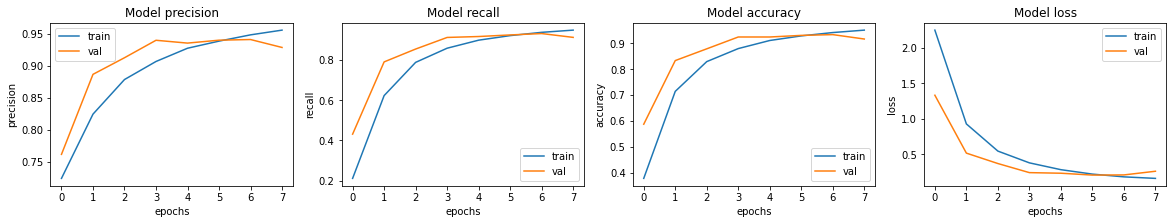

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [13]:
predictions = model.predict(test_dataset)

In [14]:
train_dataset.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

Accuracy: 0.9195476575121163
Precision: 0.9136238116446359
Recall: 0.9100441845370091
F1_score: 0.9069040560217678


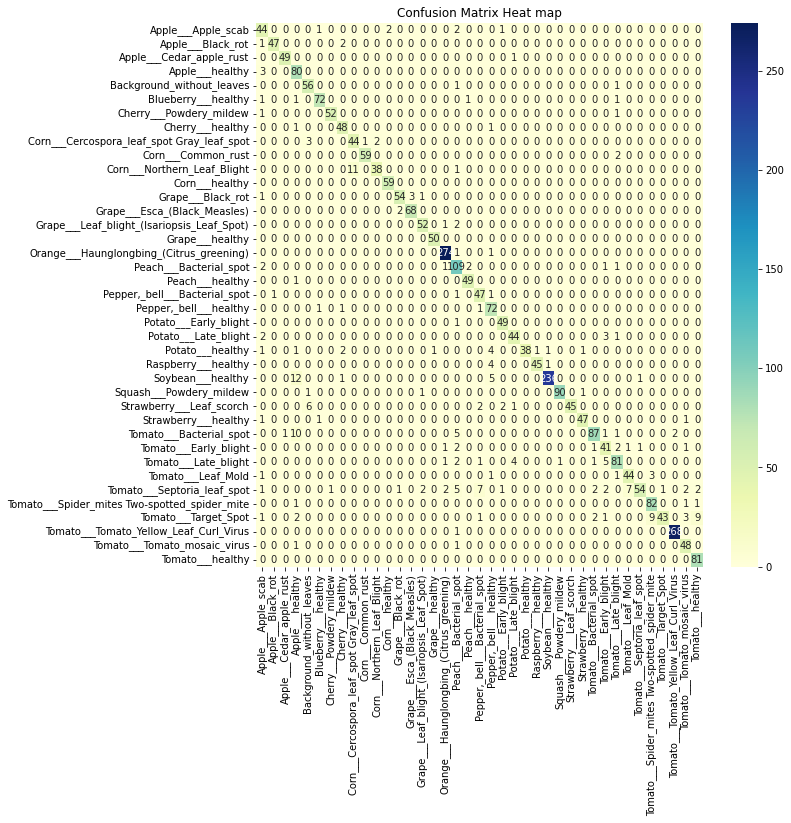

In [15]:
evaluate(test_dataset.classes,predictions)

In [16]:
model.evaluate(test_dataset)

31/31 [==============================] - 8s 260ms/step - loss: 0.2827 - accuracy: 0.9195 - precision: 0.9264 - recall: 0.9115


[0.2827358543872833,
 0.9195476770401001,
 0.9264367818832397,
 0.9114701151847839]

In [17]:
model.save("plant_badr_model_v1-beta.h5")